In [53]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import copy
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime
from collections import Counter

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, precision_score
from sklearn.model_selection import train_test_split

In [266]:
def datamap(df,params):
    #Adjust some things that are always included and may need to be used:
    df['dimain'] = df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})
    for label in params:
        #Mapping yes/no to 1/0
        if label =='date':
            df['incdate'] = pd.to_datetime(df['incdate'])
            df['date'] = (df['incdate'] - df['incdate'].min())  / np.timedelta64(1,'D')
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months
            #Mapping yes/no to 1/0
        if label=='clinjaund':
            df[label] = df.clinjaund.map({'Yes': 1, 'No': 0})
        if label=='clinhepato':
            df[label] = df.clinhepato.map({'Yes': 1, 'No': 0})
        if label=='clinspleno':
            df[label] = df.clinspleno.map({'Yes': 1, 'No': 0})
        if label=='clinconv':
            df['clinconv'] = df.clinconv.map({'Yes': 1, 'No': 0})
        if label=='clindehyd':
            df['clindehyd'] = df.clindehyd.map({'Yes': 1, 'No': 0})
        if label=='clinnoedem':
            df['clinoedem'] = df.clinoedem.map({'Yes': 1, 'No': 0})
        if label=='clinlymph':
            df['clinlymph'] = df.clinlymph.map({'Yes': 1, 'No': 0})
        if label=='clinresp':
            df['clinresp'] = df.clinresp.map({'Yes': 1, 'No': 0})
        if label=='clinablung':    
            df['clinablung'] = df.clinablung.map({'Yes': 1, 'No': 0})
        if label=='clincyan':
            df['clincyan'] = df.clincyan.map({'Yes': 1, 'No': 0})
        if label=='clincapref':
            df['clincapref'] = df.clincapref.map({'Yes': 1, 'No': 0})
        if label=='clincoldext':
            df['clincoldext'] = df.clincoldext.map({'Yes': 1, 'No': 0})
        if label=='clinorcand':
            df['clinorcand'] = df.clinorcand.map({'Yes': 1, 'No': 0})
        if label=='clinhemmor':
            df['clinhemmor'] = df.clinhemmor.map({'Yes': 1, 'No': 0})
        if label=='clinaids':
            df['clinaids'] = df.clinaids.map({'Yes': 1, 'No': 0})
        if label=='vom':
            df['vom'] = df.vom.map({'Yes': 1, 'No': 0})
        if label=='diar':
            df['diar'] = df.diar.map({'Yes': 1, 'No': 0})
        if label=='headache':
            df['headache'] = df['head'] #Since 'head' is a function
            df['headache'] = df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
        if label=='conv':
            df['conv'] = df.conv.map({'Yes': 1, 'No': 0})
        if label=='age':
            df['ageym'] = df.ageyrs.astype(float)*12.
            df['agemth'] = df.agemth.astype(float)
            df['age'] = df.ageym + df.agemth #total age in months

        #Medical history variables
        if label=='mhhosp':
            df['mhhosp'] = df.mhhosp.map({'Yes': 1, 'No':0})

        #some slightly more compliated mappings
        if label=='abdpain':
            df['abdpain'] = df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='muscle':
            df['muscle'] = df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
        if label=='mhdevsp':
            df['mhdevsp'] = df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
                   'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
                   'SPEECH DEVELOPEMENTAL DELAY':1})

        #Initial diagnosis coding:
        if label=='CMalaria':
            df['CMalaria'] = df.dimain.map({0:1,1:0,2:0,3:0})
        if label=='Enceph':
            df['Enceph'] = df.dimain.map({0:0,1:1,2:0,3:0})
        if label=='Mening':
            df['Mening'] = df.dimain.map({0:0,1:0,2:1,3:0})
        if label=='Other':
            df['Other'] = df.dimain.map({0:0,1:0,2:0,3:1})


        #This coding is going to be important. You'll want to figure out which categories are useful, and which
        #are practical.
        if label=='diag':
            df['diag'] = df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                                'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                                'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                                'tb':3,'crypto':2, '0.0':4})

In [267]:
#Read in the datafile - don't mess with it.
data_raw = pd.read_csv("../Data/cns_data.csv")   #Using Pandas for data manipulation
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

#Split up 'incdate' into month, day, and year. Monthday is meant to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['year'] = pd.DatetimeIndex(data_df['incdate']).year
data_df['monthday'] = data_df['month']*30+data_df['day']

#The set of inputs that will need mapping is small here, intentionally:
pmap = ['dimain','diag','Other','Mening','CMalaria','Enceph','age','date','headache','vom','clinhepato','clindehyd',
       'conv']
datamap(data_df,pmap);

In [273]:
#Select the diagnosis data only, then go through and calculate the proportion of the previous N patients
#that ended up with each diagnosis.
diag_data = data_df.diag.values
Ntot = len(diag_data)            #Total number of patients
N = 10                           #Number of patients to use to calculate probabilities
pdiagnosis = []                  #List to keep track of diagnoses - will be (Ntot - N) x 5
for i in range(Ntot-N):
    prev_pat = diag_data[i:N+i]
    count = [float(Counter(prev_pat)[0])/N,float(Counter(prev_pat)[1])/N, float(Counter(prev_pat)[2])/N,\
             float(Counter(prev_pat)[3])/N, float(Counter(prev_pat)[4])/N]
    pdiagnosis.append(count)

#Now go through from N to Ntot and use these probabilities to make the diagnosis. Record the predicted diagnosis
#and the true diagnosis
prediction = []
for i in range(N,Ntot):
    guess = np.random.multinomial(1,pdiagnosis[i-N])
    hold = np.where(guess==1)[0]
    prediction.append([hold[0],diag_data[i]])

prediction = np.array(prediction)
print np.shape(prediction), Ntot

(470, 2) 480


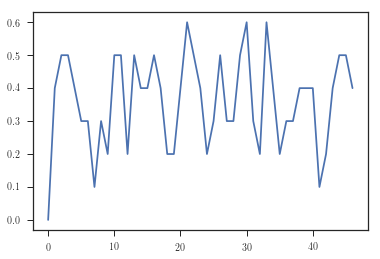

In [274]:
W = 10                               #Window over which to calculate precision
ypred = []
ytrue = []
pswind = []
for i in range(Ntot-N):
    ypred.append(prediction[i,0])
    ytrue.append(prediction[i,1])
    if i%W == 0:
        pscore = precision_score(ytrue,ypred,average='micro')
        pswind.append(pscore)
        ypred = []
        ytrue = []

plt.plot(pswind)

In [275]:
#Now, add this as a feature for classification.
data_subset = data_df[N:].copy()
pdiagnosis = np.array(pdiagnosis)

data_subset['pmal'] = pdiagnosis[:,0]
data_subset['pbac'] = pdiagnosis[:,1]
data_subset['pvir'] = pdiagnosis[:,2]
data_subset['pother'] = pdiagnosis[:,3]
data_subset['pnone'] = pdiagnosis[:,4]

#Features to classify on - as well as label, which is 'diag'. Need these in the same dataframe so you can drop
#entries with NaN as any of the values.
feature_list = ['CMalaria','Mening','Enceph','resp','card','sbp','dbp','glasgtot','temp','age','height',\
               'weight','muac','pmal','pnone','clinhepato','date','conv',\
                'diag']

XY_df = data_subset.loc[:,feature_list].dropna()
Input = XY_df.values             #creates a numpy array
Features = Input[:,0:-1].copy()  #separate the features and labels
Labels = Input[:,-1].copy()

X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=True)
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0,max_depth=10)

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
Xlabels = np.array(feature_list[:-1])
ImportantFeatures = Xlabels[indices]

print ImportantFeatures

['CMalaria' 'Enceph' 'glasgtot' 'Mening' 'muac' 'date' 'temp' 'pnone'
 'weight' 'age' 'card' 'height' 'resp' 'dbp' 'sbp' 'clinhepato' 'pmal'
 'conv']


In [286]:
def testfunc(x,p):
    m0 = p[0]
    y0 = p[1]
    x0 = p[2]
    return y0 + m0/(x-x0)

In [287]:
x = np.linspace(0,60,61)

In [311]:
y = testfunc(x,[1.8,0.2,500.])

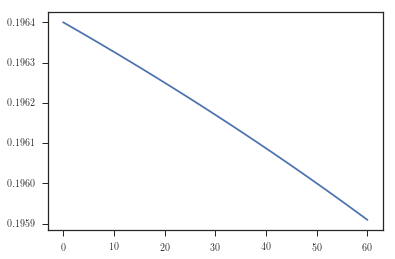

In [312]:
plt.plot(x,y)